In [1]:
import os
import re
import boto3
import itertools
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker.session import Session

In [2]:
# create a darker background template (better for my eyes)
from jupyterthemes.stylefx import set_nb_theme
# set_nb_theme('chesterish')

## Helper Functions & Classes

In [3]:
# small class for holding "special" print flags
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [4]:
def QAcheck(tests, checks, func):
    """
    Quality-assurance checks for expected outputs, and function outputs
    """
    for index, test in enumerate(tests):
        value = func(test)
        
        if type(value) == np.ndarray:  
            if (value == checks[index]).all():
                print('Correct Match\t{} = {}'.format(tests[index], checks[index]))
        else:
            if (value is checks[index]):
                print('Correct Match\t{} = {}'.format(tests[index], checks[index]))
            elif (value == checks[index]):
                print('Correct Match\t{} = {}'.format(tests[index], checks[index]))
            else:
                print(color.BOLD,color.RED,'ERROR MATCH\t{} /= {}'.format(tests[index], checks[index]),color.END)

In [5]:
def cleanNumeric(value) -> float:
    """
    This function converts a string to a numeric quantity, handles weird string format
    :param: value, string value with hidden numeric quanity  
    :return: floating point values
    
    Complexity -> O(n)
    
    e.g.
        In[0]: $ 19,225     ->   Out[0]: 19255
        In[0]: $ 19,225.76  ->   Out[0]: 19255.76
        
    """
    
    assert type(value) is str or int or np.ndarray, 'Value must be of type string, integer, float or numpy array'
    
    # checks to see what type of value is being provided
    operator = type(value)
    
    def num_strip(number):
        """
        Nested function for extracting numerical quantities
        """
        try:
            # some accounting formats take () to be negative numbers
            if number[0] == '(':
                number = '-' + number

            # perform regex operation scanning for only numeric quantities/identifiers
            cleanValue = re.sub("[^0-9|.|-]", "", number)

            # last check against poor lagging formats e.g. "." or "-" to return nan or floating-point number
            try: 
                return float(cleanValue)
            except ValueError: 
                return np.nan
            
        except (TypeError, IndexError):
            return np.nan
    
    # if provided a string, perform regex operation 
    if (operator is str) and (len(value) > 0):
        return num_strip(value)
    
    # if operator is integer then simply return the value, no need to modify 
    elif (operator is int):
        return value
    
    # if operator is numpy array then we perform a extraction per element in array
    elif (operator is np.ndarray):
        vFunc = np.vectorize(num_strip)      # vectorize function to apply to numpy array
        cleanValue = vFunc(value)            # apply vector function
        return cleanValue
    
    else:
        return np.nan

In [6]:
tests = np.array(['', '$.', '$ -', '.3', '128,123', '-$24,613', '(21,843)', '$212,223',
                 np.array(['$13,300', '-$2344', '$23,421']), np.array(['$13,300', np.nan, '$23,421']),
                 np.array([np.nan, np.nan])])
expectation = np.array([np.nan, np.nan, np.nan, 0.3, 128123.0, -24613.0, -21843.0, 212223.0, 
                        [13300., -2344., 23421.], [13300., np.float64(np.nan), 23421.], 
                        [np.float64(np.nan), np.float64(np.nan)]])

QAcheck(tests, expectation, cleanNumeric)

Correct Match	 = nan
Correct Match	$. = nan
Correct Match	$ - = nan
Correct Match	.3 = 0.3
Correct Match	128,123 = 128123.0
Correct Match	-$24,613 = -24613.0
Correct Match	(21,843) = -21843.0
Correct Match	$212,223 = 212223.0
Correct Match	['$13,300' '-$2344' '$23,421'] = [13300.0, -2344.0, 23421.0]


In [7]:
def regexCheck(string:str, searchTerm:str):
    """
    Checks a regex expression for a given string construct
    string (type str)
        A string to perform a regex search on e.g. "Cash and cash equiavalents"
    searchTerm (type str)
        A regex expression to execute a search e.g. "^Cash"
        
    return: the searched term in question
    """
    try:
        s = re.search(searchTerm, string, flags=re.I)
        return s.string
    except AttributeError:
        return None

In [8]:
# sample = "Total Liabilities stockholder's equity"
sample = "MEMBER'S EQUITY"
regexCheck(sample, '^(?!.*liabilities).*equity$')

"MEMBER'S EQUITY"

In [9]:
def tMatch(totalA:float, totalLE:float):
    # helps match the accounting equation assets = libabilities + equities 
    try:
        multiplier = totalA / totalLE
        
        # if multiplier is zero, then total asset column is zero, we return nothing (imperfect)
        if multiplier == 0: return (None, 'Asset table is missing')
        
        # if multiplier is non-negative we accept only 1 or multiples of 10 (perfect and semi-perfect)
        elif (multiplier == 1) or (multiplier%10 == 0): return (multiplier, 'Perfect/Semi-Perfect match')
        
        # all other multipliers, should return nothing (number mismatch) 
        else: return (None, 'Accounting Error')
        
    # if total liabilites doesn't exist, but total assets either exists or does not exist  
    except ZeroDivisionError:
        return (None, "Either Liabilities/Equities doesn't exist or both Total Assets and Liabilities/Equities missing")

In [10]:
print(tMatch(totalA=0, totalLE=100))
print(tMatch(totalA=0, totalLE=0))
print(tMatch(totalA=100, totalLE=0))
print(tMatch(totalA=100, totalLE=100))
print(tMatch(totalA=10000, totalLE=100))
print(tMatch(totalA=102020, totalLE=11))

(None, 'Asset table is missing')
(None, "Either Liabilities/Equities doesn't exist or both Total Assets and Liabilities/Equities missing")
(None, "Either Liabilities/Equities doesn't exist or both Total Assets and Liabilities/Equities missing")
(1.0, 'Perfect/Semi-Perfect match')
(100.0, 'Perfect/Semi-Perfect match')
(None, 'Accounting Error')


## Interact with System Environment

In [11]:
# initiate s3 bucket and corresponding data folder
bucket = "ran-s3-systemic-risk"
data_folder ="Output/BalanceSheet/"

# Amazon Textract client and Sagemaker session
textract = boto3.client('textract')
s3 = boto3.client('s3')
session = Session()

# discover all of the pdfs that you want to parse
paths = np.array(session.list_s3_files(bucket, data_folder))

In [12]:
print('Total cleaned .csv files total {}'.format(paths.size-1))

Total cleaned .csv files total 15888


# X-17A-5 Database Construction

In [21]:
# J.P. MORGAN SECURITIES LLC, GOLDMAN SACHS & CO. LLC, MORGAN STANLEY & CO. LLC, CITIGROUP GLOBAL MARKETS INC.
# NOMURA SECURITIES INTERNATIONAL, INC., WELLS FARGO SECURITIES, LLC, BARCLAYS CAPITAL INC.
# HSBC SECURITIES (USA) INC., DEUTSCHE BANK SECURITIES INC.
big_banks = ['782124', '42352', '68136', '91154', '72267', '1224385', '851376', '853784', '58056']

# list of big banks paths, we search for postive value denoting occurence
bankPaths = [path for cik in big_banks for path in paths if str.find(path, cik) > 0]

In [22]:
# select n samples to construct cluster algorithm and then shuffle 
n = 1000
obsRange = np.append(paths[1:n-len(bankPaths)], bankPaths)
np.random.shuffle(obsRange)

In [25]:
obsRange

array(['Output/BalanceSheet/1003676-08.csv',
       'Output/BalanceSheet/1002599-09.csv',
       'Output/BalanceSheet/1002201-06.csv',
       'Output/BalanceSheet/1002201-09.csv',
       'Output/BalanceSheet/1002196-02.csv',
       'Output/BalanceSheet/1001366-07.csv',
       'Output/BalanceSheet/1001736-02.csv',
       'Output/BalanceSheet/1002603-09.csv',
       'Output/BalanceSheet/1001371-09.csv',
       'Output/BalanceSheet/1000317-03.csv',
       'Output/BalanceSheet/1000147-05.csv',
       'Output/BalanceSheet/1224385-05.csv',
       'Output/BalanceSheet/1002202-15.csv',
       'Output/BalanceSheet/1004323-02.csv',
       'Output/BalanceSheet/1001371-02.csv',
       'Output/BalanceSheet/1003316-02.csv',
       'Output/BalanceSheet/851376-06.csv',
       'Output/BalanceSheet/1002006-13.csv',
       'Output/BalanceSheet/1000151-10.csv',
       'Output/BalanceSheet/1000317-20.csv',
       'Output/BalanceSheet/1001692-09.csv',
       'Output/BalanceSheet/1000490-04.csv',
       'Out

## Balance Sheet item extraction
**We start by retrieving all asset line items as well as liability & equity line items**

In [34]:
def balanceSheetLines(fileNames:np.ndarray) -> tuple:
    """
    Retrieving balance sheet information line item names for s3 files
    :param: (type np.ndarray)
        An array of file names for .csv files from s3
        
    :return: (type tuple)
        Return a tuple of arrays; left is the asset items, and right is the liability & equity items 
    """
    
    # initialize asset and liability list to store items
    Asset = []
    LiabilityandEquity = []

    # iterate through files from s3 bucket 
    for file in fileNames:
        
        # download temporary file from s3 bucket
        s3.download_file(bucket, file, 'temp.pdf')
        df = pd.read_csv('temp.pdf')
        
        n = df.columns.size   # the number of columns in read dataframe
        
        if n > 1: # if there is more than 1 column we continue examination 
            
            arr = df[df.columns[1]].dropna().values     # all line item for balance sheet (second column)
            
            # iterate through the line items as provided by the array
            for i, item in enumerate(arr):
                
                # search string for presence of word 'liabilties' or 'liability' 
                val = re.search('liabilities|liability ', item, flags=re.I)
                
                # if we find the term 'liability' or 'liabilities' we split the line items and break inner loop
                if val is not None:
                    
                    # partition by the enumerated index for asset and liability portions
                    Asset.append(arr[:i])
                    LiabilityandEquity.append(arr[i:])
                    break
                    
        # remove local file after it has been created
        os.remove('temp.pdf')
    
    # flatten series for all values
    left = np.hstack(np.array(Asset))
    right = np.hstack(np.array(LiabilityandEquity))
    
    return (left, right)

In [35]:
leftSide, rightSide = balanceSheetLines(obsRange)

In [36]:
# storing unique list of asset items and liability line items
with open('assetLines.txt', 'w') as f: json.dump(list(set(leftSide)), f)
with open('liabilityLines.txt', 'w') as f: json.dump(list(set(rightSide)), f)

print('All line items have been stored from balance sheet reading\n\tAsset items are stored\n\tLiability & Equity items are stored')

All line items have been stored from balance sheet reading
	Asset items are stored
	Liability & Equity items are stored


## Unstructured Data formulation
**Use the extracted asset and liaiblity lines to construct a large panel dataset, where line items are columns**

In [37]:
with open('assetLines.txt', 'r') as f: assetSide = json.loads(f.read())
with open('liabilityLines.txt', 'r') as f: liableSide = json.loads(f.read())
    
print('Asset and Liabilities & Equity lines have been loaded in from JSON')

Asset and Liabilities & Equity lines have been loaded in from JSON


In [38]:
assetDict = dict([(i, np.nan) for i in assetSide])
liableDict = dict([(i, np.nan) for i in liableSide])

In [39]:
def unstructured_data(filepaths, lineDictionary, lineItems) -> tuple:
    """
    Forms unstructured data frame from .csv file(s) located in s3 bucket
    
    :param: filepaths
        filepaths from s3 that store .csv file(s) (Output/BalanceSheet/)
    :paran: lineDictionary
        dictionary of total unstructured line items and corresponding values
    :paran: lineItems
        list of line items (asset/liabilites) that will be searched for
        
    :return: tuple
        Returns a tuple, itters is a list of dataframes representing line items, error is a dictionary
        tracking all error terms that exist due to univariate dataframes 
    """
    
    # intialize list to store dataframes and errors
    itters = []
    error = {}

    # iterate through files from s3 
    for file in filepaths:
        
        # create temporary dictionary copy for storage of values
        tempDict = lineDictionary.copy()
          
        # creating two rows to track the CIK and year information released
        cik, year = file.split('/')[-1].split('-')

        tempDict['CIK'] = cik                 # CIK number for firm 
        tempDict['Year'] = '20' + year[:2]    # Year for firm filing  
        
        # retrieving downloaded files from s3 bucket
        s3.download_file(bucket, file, 'temp.pdf')
        df = pd.read_csv('temp.pdf')

        # clean dataframes for only the items and their immediate values
        cleanDF = df[df.columns[1:]] 

        # clean dataframe should be of size greater than 1
        if len(cleanDF.columns) > 1:
            
            # extract line items from each dataframe (balance sheet)
            lines = cleanDF[cleanDF.columns[0]]
            
            # filter dataframes according line items, and extract numerical values from dataframe 
            filterDF = cleanDF[np.isin(lines, lineItems)]
            filterDF = filterDF.set_index(filterDF.columns[0])             # set line items as index
            filterDF = filterDF.apply(lambda x: cleanNumeric(x.values))    # extract numerical figures

            # iterate through items from (asset or liability items)
            for item in filterDF.index:
                lineVal = filterDF.loc[item]                 # line item e.g. Cash $72,343 $71,231
                
                # check to see scope of line value, checking if multi-columns present
                # in the event we have repeating 'item' lines (e.g. 2 Prepaid expense) we sum columns  
                if type(lineVal) is not pd.Series:
                    lineVal = lineVal.sum()
                
                value = lineVal.iloc[0]                      # first column value e.g. 72343
                
                # value of line items for the adjacent column (current year)
                if ~np.isnan(value):
                    tempDict[item] = value
                    
                else:
                    try:
                        # if the first column is blank we assume the second column is filled with totals
                        value = lineVal.iloc[1]
                        
                        # if second column value is not-nan we attach those values
                        if ~np.isnan(value):
                            tempDict[item] = value
                    
                    # if no second column exists, we ignore and pass
                    except IndexError: pass
            
            # convert the dictionary values to dataframe for database construction 
            row = pd.DataFrame.from_dict(tempDict, orient='index')
            
            # append dataframe set to array transposing 
            itters.append(row.transpose())
            
        else:
            error[file] = 'Issue reading PDF'
        
        # remove local file after it has been created
        os.remove('temp.pdf')
    
    return itters, error

In [40]:
# the output directory for both asset and liability figures 
assetItters, errors = unstructured_data(obsRange, assetDict, list(assetDict.keys()))
assetDF = pd.concat(assetItters)

liableItters, errors = unstructured_data(obsRange, liableDict, list(liableDict.keys()))
liableDF = pd.concat(liableItters)

In [41]:
# re-order the CIK and Year columns to appear as the first two columns
remap = assetDF.columns[~np.isin(assetDF.columns, ['CIK', 'Year'])]
unstructADF = assetDF[np.insert(remap, [0, 0], ['CIK', 'Year'])]

In [42]:
# filter out columns with NaN values, return only values
filterNaN = unstructADF.isnull().all()
cleanCols = filterNaN[filterNaN == False].index

In [43]:
unstructADF[cleanCols].head()

,CIK,Year,Receivable from clearing broker/dealer,"Securities received as collateral, at fair value (approximately $14,956 were pledged to various parties)","Investment, at fair value",Allocated pension asset,"Trading assets ($16,658,256 were pledged to various parties and $437,502 related","Property and equipment, net of accumulated depreciation of $198,744",Receivables from broker-dealers and clearing organizations,"Total financial instruments owned, at fair value",...,"Securities borrowed or purchased under agreements to resell (including $93,975 at fair value)",U.S. government and government agency,accumulated depreciation and amortization of $884,Other Assets Deposits with clearing organizations and others,Receivable from noncustomer,Customers,"Cash and securities segregated for benefit of customers (includes securities at fair value of $5,709)","Investments, at cost",Prepaid and other assets,"Furniture, equipment and leasehold improvements, (net of accumulated depreciation and amortization of $2,066,104)"
0,1000148,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1001710,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1002006,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1003316,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1001383,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
unstructADF[cleanCols].to_csv('unstructAssetSample.csv', index=False)

In [45]:
# re-order the CIK and Year columns to appear as the first two columns
remap = liableDF.columns[~np.isin(liableDF.columns, ['CIK', 'Year'])]
unstructLDF = liableDF[np.insert(remap, [0, 0], ['CIK', 'Year'])]

In [46]:
# filter out columns with NaN values, return only values
filterNaN = unstructLDF.isnull().all()
cleanCols = filterNaN[filterNaN == False].index

In [47]:
unstructLDF[cleanCols].head()

,CIK,Year,"Common stock ($10,000 par value, 1,000 shares authorized, issued and outstanding)",10 shares issued and outstanding,Profit sharing payable,Due customer,TOTAL LIABILITY AND STOCKHOLDER'S EQUITY,Accumulated other comprehensive income (loss),Total liabilities and stockholder's,Noncontrolling interest,...,"1,000 shares issued and outstanding",Customers,Notes payable (Note 7),Debt securities sold under agreements to repurchase,Morgan Stanley & Co. LLC member's equity,"Liability, accounts payable",Total liabilities and members' capital,Total lia bilities,"7,928,750 shares issued and outstanding","authorized, 100 issued and outstanding"
0,1000148,2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1001710,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1002006,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1003316,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1001383,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
unstructLDF[cleanCols].to_csv('unstructLiableSample.csv', index=False)

## Line Item Label Clustering
**Using KMeans clustering for determing word similitaries amongst balance sheet items**

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import AffinityPropagation, KMeans, AgglomerativeClustering

In [14]:
def word_matching(array: np.array, vectorizer_class, cluster_class) -> tuple:
    
    # Convert a collection of text documents to a matrix of token counts
    vectorizer = vectorizer_class
    print('Using the {} text vectorizer\n'.format(type(vectorizer_class).__name__))
    
    # produces a sparse representation of the counts using scipy.sparse.csr_matrix.
    X = vectorizer.fit_transform(array)
    
    # initialize the clustering model on words
    model = cluster_class
    
    model.fit(X)  # fit clustering model to array of strings

    # returns dataframe, mapping cluster labels to line items
    outDF = pd.DataFrame({'Labels': model.labels_, 'LineItems': array})
    
    print('\n{} clusters were found using {} algorithm'.format(model.labels_.max()+1, type(cluster_class).__name__))
    
    return model.labels_, model.cluster_centers_, outDF 

In [15]:
# reading cleaned unstructured data sets for samples 
assets = pd.read_csv('unstructAssetSample.csv')
liability = pd.read_csv('unstructLiableSample.csv')

**The following clustering model specifications are outlined below:**

- **array:** We select the columns from either asset or liability tables, not including CIK or Year components.
- **vectorizer_class:** We implement a standard TfidVectorizer class, converting the collection of strings to a matrix of TF-IDF features.

- **cluster_class:** We fit a KMeans clustering algorithm, employing **35 cluster** using the the classic **expectation–maximization algorithm (full)** for computing the KMeans clusters with **25 centroid seeds** to check against. We also control the random state and provided verbosity to model fits

In [39]:
clusters = 35
text_vectorizer = TfidfVectorizer(lowercase=True)
cluster_mdl = KMeans(n_clusters=clusters, n_init=25, verbose=1, random_state=1, algorithm='full')

In [62]:
# perform clustering on the asset line items
assetTerms = assets.columns.values[2:]
np.random.shuffle(assetTerms)

# divide asset terms into in and out of sample categories
insAssets = assetTerms[:-50]
outAssets = assetTerms[-50:]
assetlabel, assetCenters, df1 = word_matching(array = insAssets, vectorizer_class = text_vectorizer, 
                                              cluster_class = cluster_mdl)

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration  0, inertia 1254.113
Iteration  1, inertia 1069.172
Iteration  2, inertia 1020.947
Iteration  3, inertia 999.226
Iteration  4, inertia 983.819
Iteration  5, inertia 966.826
Iteration  6, inertia 961.153
Iteration  7, inertia 960.189
Iteration  8, inertia 960.034
Iteration  9, inertia 959.980
Iteration 10, inertia 959.002
Iteration 11, inertia 958.809
Iteration 12, inertia 957.937
Iteration 13, inertia 957.375
Iteration 14, inertia 957.303
Iteration 15, inertia 957.261
Converged at iteration 15: center shift 0.000000e+00 within tolerance 9.195306e-08
Initialization complete
Iteration  0, inertia 1599.447
Iteration  1, inertia 978.106
Iteration  2, inertia 959.882
Iteration  3, inertia 949.497
Iteration  4, inertia 944.136
Iteration  5, inertia 941.436
Iteration  6, inertia 940.357
Iteration  7, inertia 939.642
Iteration  8, inertia 938.843
Iteration  9, inertia 938.190
Iteration 10, inertia 937.673
Iteration 11

Initialization complete
Iteration  0, inertia 1585.442
Iteration  1, inertia 973.483
Iteration  2, inertia 955.682
Iteration  3, inertia 947.942
Iteration  4, inertia 943.516
Iteration  5, inertia 940.338
Iteration  6, inertia 937.941
Iteration  7, inertia 937.473
Iteration  8, inertia 937.092
Iteration  9, inertia 936.864
Iteration 10, inertia 936.836
Converged at iteration 10: center shift 0.000000e+00 within tolerance 9.195306e-08
Initialization complete
Iteration  0, inertia 1246.029
Iteration  1, inertia 1040.293
Iteration  2, inertia 991.443
Iteration  3, inertia 975.387
Iteration  4, inertia 967.752
Iteration  5, inertia 964.982
Iteration  6, inertia 962.048
Iteration  7, inertia 960.299
Iteration  8, inertia 958.379
Iteration  9, inertia 957.408
Iteration 10, inertia 956.781
Iteration 11, inertia 956.481
Iteration 12, inertia 956.381
Converged at iteration 12: center shift 0.000000e+00 within tolerance 9.195306e-08
Initialization complete
Iteration  0, inertia 1583.351
Iteratio

In [63]:
# perform clustering on the liability & equity line items
liabilityTerms = liability.columns.values[2:]
np.random.shuffle(liabilityTerms)

# divide liability terms into in and out of sample categories
insLiability = liabilityTerms[:-50]
outLiability = liabilityTerms[-50:]

liabilitylabel, liabilityCenters, df2 = word_matching(array = insLiability, vectorizer_class = text_vectorizer, 
                                                      cluster_class = cluster_mdl)

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration  0, inertia 922.713
Iteration  1, inertia 597.748
Iteration  2, inertia 586.556
Iteration  3, inertia 581.173
Iteration  4, inertia 578.681
Iteration  5, inertia 576.311
Iteration  6, inertia 575.196
Iteration  7, inertia 574.983
Converged at iteration 7: center shift 0.000000e+00 within tolerance 1.664100e-07
Initialization complete
Iteration  0, inertia 969.287
Iteration  1, inertia 603.576
Iteration  2, inertia 593.093
Iteration  3, inertia 586.691
Iteration  4, inertia 582.805
Iteration  5, inertia 580.616
Iteration  6, inertia 579.226
Iteration  7, inertia 579.023
Iteration  8, inertia 578.813
Iteration  9, inertia 578.491
Iteration 10, inertia 578.235
Iteration 11, inertia 578.113
Iteration 12, inertia 578.086
Converged at iteration 12: center shift 0.000000e+00 within tolerance 1.664100e-07
Initialization complete
Iteration  0, inertia 930.434
Iteration  1, inertia 603.966
Iteration  2, inertia 582.881


Initialization complete
Iteration  0, inertia 966.530
Iteration  1, inertia 609.653
Iteration  2, inertia 599.297
Iteration  3, inertia 594.135
Iteration  4, inertia 591.749
Iteration  5, inertia 585.906
Iteration  6, inertia 581.913
Iteration  7, inertia 579.986
Iteration  8, inertia 579.080
Iteration  9, inertia 578.144
Iteration 10, inertia 577.415
Iteration 11, inertia 576.303
Iteration 12, inertia 576.001
Iteration 13, inertia 575.295
Iteration 14, inertia 574.129
Iteration 15, inertia 573.383
Iteration 16, inertia 573.361
Converged at iteration 16: center shift 0.000000e+00 within tolerance 1.664100e-07
Initialization complete
Iteration  0, inertia 965.561
Iteration  1, inertia 598.203
Iteration  2, inertia 584.607
Iteration  3, inertia 580.979
Iteration  4, inertia 576.618
Iteration  5, inertia 573.854
Iteration  6, inertia 571.564
Iteration  7, inertia 570.219
Converged at iteration 7: center shift 0.000000e+00 within tolerance 1.664100e-07
Initialization complete
Iteration  0,

### Examination of Clusters Realiablity
**Observing the distance between cluster centroids, tracking numerical difference relative to other labels**

In [42]:
def distance_matrix(centers: np.ndarray):
    clusters, nfeatures  = centers.shape
    itRange = np.arange(clusters)
    
    # similar to covariance matrix, initialize memory for distance matrix
    dMat = np.zeros((clusters, clusters))
    
    for i in itRange:
        for j in itRange:
            # computing the distance between centroids to examine label closeness
            distance = np.sqrt(np.sum(np.square(centers[i, :] - centers[j, :])))
            
            # assign values to the corresponding distance matrix
            dMat[i, j] = distance
    
    return dMat

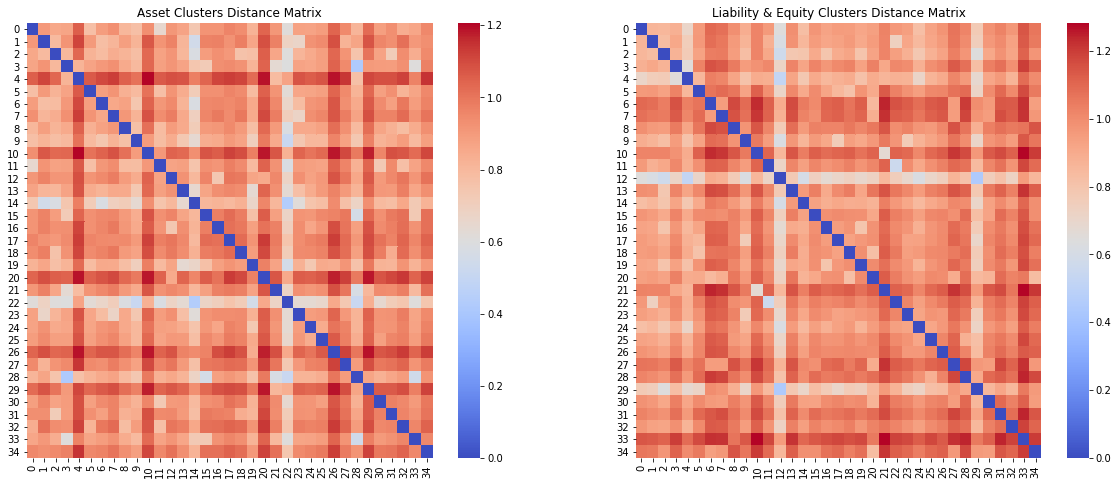

In [43]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)
sns.heatmap(distance_matrix(assetCenters), cmap='coolwarm', ax=axes[0])
sns.heatmap(distance_matrix(liabilityCenters), cmap='coolwarm', ax=axes[1])
axes[0].set_title('Asset Clusters Distance Matrix')
axes[1].set_title('Liability & Equity Clusters Distance Matrix')
plt.show()

Clustering works to great effect with the vast majority of cases presented, but there still appears to be issues that persist when trying to divide the current dataset - namely more nuanced differences such as "Total Liabilites and Equity" and "Total Equity". I want to try grouping these and then clustering them again.

As exhbited, repeated clustering on a smaller subset of line items does not break it into expected groups. Rather, we arrive at similar breaks that we saw before when using a smaller KMeans cluster set. Hence, I will pursue the LDA as is, and see the label identificaition that follows.

## Latent Dirichlet Allocation with online variational Bayes algorithm
**A Topic Model for root-word detection from a list of similar strings** 

Our goal here is to determine whether using LDA decomposition is useful in determining label names for clustering classes

* The corpus is a collection of **D** documents, which will be a cluster with corresponding word groupings from KMeans
* A document is a sequence of **N** words, which corresponds to the sequence of characters of each word in the cluster
* There are **K** topics in the corpus, which will be one as we are looking to determine roots

In [64]:
from sklearn.decomposition import LatentDirichletAllocation

In [65]:
def label_LDA(names, LDA_model):
    assert type(LDA_model).__name__ is 'LatentDirichletAllocation', 'Model restriction, only imposed LDA'
    
    print('Clustered names provided are:\n\n', names, '\n')
    labelNames = []
    
    # vectorize the text (string) data to be used by Latent Dirichlet Allocation algorithm
    text_mdl = TfidfVectorizer()
    vec_text = text_mdl.fit_transform(names)
    
    # feature names extracted from the TfidVectorizer
    feature_names = text_mdl.get_feature_names()
  
    # fit Laten Dirichlet Allocation model 
    mdl = LDA_model
    mdl.fit(vec_text)
    
    print()
    # print out label names determined from LDA
    for topic in mdl.components_:
        message = "Topic determined: "
        message += " ".join([feature_names[i]
                             # select the 5 most important feature names from largest to smallest order
                             for i in topic.argsort()[:-5 - 1:-1]])
        print(color.BOLD, message, color.END)
        labelNames.append(message)
    print()
    
    return labelNames

Continuing this current assesment of topic detection, we extend this to the entire subset of items computed from the clustering algorithm employed to group each of the asset/liability line items grouped before. **(Refer to KMeans Model for details on clustering)**


In [66]:
# creating names for assest line clusters
for i in range(df1.Labels.max()+1):
    print('Label', i)
    cluster_cells = df1[df1.Labels == i]['LineItems'].values
    print()
    _ = label_LDA(cluster_cells, 
                  LatentDirichletAllocation(n_components=1, verbose=1, random_state=1))
    print()

Label 0

Clustered names provided are:

 ['Securities owned, not readily marketable, at estimated fair value'
 'Trading inventory, at market value'
 'Marketable securities, at market value'
 'Trading inventory, at market value, pledged'
 'Marketable debt securities' 'Securities owned, at market'
 'Marketable Securities @ FMV'
 'Marketable securities owned, at cost (identified cost - $33,100)'
 'Not readily marketable, at estimated fair value'
 'Securites owned, not readily marketable, at estimated fair value'
 'Securities owned, at market value (Notes 1 and 2)'
 'Securities owned. at market value'
 'Trading inventory, at market value, pledged (Note 4)' 'Securities owned'
 'Securities owned, at estimated fair value'
 'Securities owned, pledged to counterparties'
 'Marketable, at market value' 'Securities owned at market value'
 'Securities owned, at market value' 'Securities'
 'Securities owned, at market (note 2)'
 'Marketable securities, at fair value' 'Securities owned, at fair value


 Topic determined: of and amortization accumulated depreciation 


Label 4

Clustered names provided are:

 ['Other Assets' 'Other current assets' 'Other'
 'Other assets Mail Processing' 'Other Assets: Rent Deposit'
 'PREPAID EXPENSES AND OTHER ASSETS'
 'Prepaid expenses & other current assets' 'Prepaid expenses and other'
 'Prepaid expenses and other assets (Note 5)'
 'Prepaid expenses and other assets' 'Other assets'
 'Prepaid administrative services and other expenses, related party'
 'Other assets Security deposit' 'Other Asset' 'Prepaid and other assets'
 'Fees and other' 'Corporate and other debt'
 'Other assets (Notes 8 and 9)' 'OTHER ASSETS'
 'Other Assets Security deposit'
 'Prepaid expenses and other assets (Note 4)' 'Other asset'
 'Prepaid expenses and other current assets' 'Other Other assets assets'
 'Prepaid administrative services and other expenses'
 'Note 12. Other Assets' 'Deposits and other assets'
 'Other debt securities'] 

iteration: 1 of max_iter: 10
iteration: 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: cash equivalents and restricted note 


Label 10

Clustered names provided are:

 ['Due from broker (note 2)' 'Due from Broker'
 'Due from broker for securities'
 'Due from broker-dealer (Notes 1 and 11)' 'Clearing broker'
 'Due from broker, securities owned'
 'Increase (Decrease) in Due to Broker' 'Broker-dealer commissions'
 'Due from correspondent broker' 'Due from clearing broker'
 'Due to Broker' 'Due from broker-dealers (Note 1)'
 'Due from Broker Dealer' 'Clearing deposit and due from broker'
 'Due from broker-dealer (Notes 1 and 10)' 'Due from broker'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iter

iteration: 10 of max_iter: 10

 Topic determined: equipment furniture and net office 


Label 13

Clustered names provided are:

 ['Receivable from affiliate' 'Receivable from broker'
 'Receivable from Alton Capital Management, Inc.'
 'NOTE RECEIVABLE FROM AFFILIATE' 'RECEIVABLE FROM BROKER/DEALER'
 'Receivable from Others' 'Receivable from related party'
 'Broker-dealer commissions receivable'
 'Receivable from Parent and affiliated company'
 'Broker-dealer commission receivable' 'Receivable from brokers'
 'Note receivable from client' 'Receivable from Affiliates'
 'Receivable from Customer' 'Receivable from clearing broker-dealer'
 'Receivable from Clearing Broker' 'Note receivable from employee'
 'Receivable from parent' 'Receivable from noncustomer'
 'Receivable from related parties'
 'Accounts Receivable from broker-dealer' 'Receivable from broker/dealer'
 'Receivable from Non-Customer' 'Receivable from customers'
 'Receivable from related parties (Note 3)'
 'Receivable from clear

iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: of depreciation accumulated equipment net 


Label 17

Clustered names provided are:

 ['Deferred Tax Asset - Federal' 'Deferred Tax Asset Federal'
 'Deferred tax asset - net' 'Deferred tax asset, net (Note 4)'
 'Deferred tax (note 4)' 'Deferred Tax Asset - States'
 'Deferred tax asset (Note 1)' 'Net deferred tax asset'
 'Deferred tax assets net' 'Deferred Tax Asset - State'
 'Deferred tax asset' 'DEFERRED TAX ASSET' 'Deferred income tax asset'
 'Deferred commissions' 'Deferred tax asset, net (Note 5)'
 'Deferred income tax assets' 'Deferred tax assets'
 'Deferred tax asset, net' 'Deferred tax assets - net'
 'Deferred tax asset (Note 8)' 'Deferred Tax Asset States'
 'Deferred tax asset (note 5)' 'Deferred income tax assets, net'
 'Deferred Tax Asset' 'Deferred tax asset, net (Note 6)'
 'Deferred income tax'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4

iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: prepaid expenses insurance rent taxes 


Label 23

Clustered names provided are:

 ['Unearned income' 'State Income Taxes Payable' 'Deferred Taxes - State'
 'Federal Income Tax Payable' 'Prepaid income taxes'
 'Deferred income taxes, net' 'Increase in income taxes recoverable'
 'Refundable income taxes' 'Federal income taxes receivable'
 'Income taxes recoverable' 'Income taxes receivable'
 'State and Local Income Tax Receivable' 'Note 7. Income taxes'
 'Deferred taxes' 'Income tax receivable' 'Federal Income Taxes Payable'
 'Net income' 'Income tax refund receivable' 'Prepaid State Income Taxes'
 'Federal income tax receivable' 'Accounts recivable - income tax'
 'Refundable Income Tax - Federal' 'Deferred in

iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: memberships market exchange at cost 


Label 29

Clustered names provided are:

 ['Investment in security, at fair value' 'Investment (equity securities)'
 'Investment (note 4)' 'Investment in private company, at fair value'
 'Investment in securities, at fair value' 'OTHER ASSETS Investment'
 'Investment in NASDAQ' 'Investment - NASDAQ' 'Investment, at fair value'
 'Investment in broker-dealer' 'Investment in partnership'
 'Investment income receivable' 'Investment'
 'Unrealized gain on investment'
 'Investment in partnership, at fair value'
 'Other Assets: Investment in Equity Securities (at fair market value)'
 'Investment in Morgan Stanley Smith Barney Holdings LLC (including Preferred Securities of $2,153)'
 'Investment advisory fee

In [67]:
# creating names for liability line clusters
for i in range(df2.Labels.max()+1):
    print('Label', i)
    cluster_cells = df2[df2.Labels == i]['LineItems'].values
    print()
    _ = label_LDA(cluster_cells, 
                  LatentDirichletAllocation(n_components=1, verbose=1, random_state=1))
    print()

Label 0

Clustered names provided are:

 ["Member's Equity" 'Loan payable to member' "Member's equity:"
 'Class A Member' 'Payable to Member' "Member's equity"
 "Total liabilities and member's capital" "Member's distribution payable"
 "TOTAL LIABILITIES AND MEMBER'S EQUITY" 'Due to member'
 "Total member's equity" "Morgan Stanley & Co. LLC member's equity"
 "TOTAL LIABILITIES AND MEMBER'S CAPITAL" "Member's interest"
 "Member's capital" "Member's contributions"
 "Total Morgan Stanley & Co. LLC member's equity"
 "TOTAL LIABILITIES & MEMBER'S EQUITY"] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: member equity total liabilities capital 


Label 1

Clustered names provided are:

 ['and outstanding 1,000 shares'
 'shares; 805,0


 Topic determined: borrowings term short long unsecured 


Label 5

Clustered names provided are:

 ['Securities loaned or sold under agreements to repurchase (including $8,793 at fair value)'
 'agreements:'
 'Securities sold under agreements to repurchase (includes $29,028 at fair value)'
 'Securities sold under agreements to repurchase (includes $730 at fair value)'
 'Collateralized agreements and financings: Securities sold under agreements to repurchase (includes $20,303 at fair value) Securities loaned (includes $555 at fair value)'
 'Securities sold under agreements to repurchase (includes $43,513 at fair value)'
 'Securities sold under agreements to'
 'Securities sold under agreements to repurchase (includes $1,415,083 at fair value)'
 'Securities loaned and sold under agreements to repurchase (including $6,521 at fair value)'
 'Financial instruments sold under agreements to repurchase'
 'Collateralized agreements and financings: Securities sold under agreements to repurchase (


 Topic determined: accrued liabilities payroll and compensation 


Label 11

Clustered names provided are:

 ["Retained earnings Total Stockholders' equity" 'Retained earnings'
 'Retained earnings (deficit)' 'Retained earnings:'
 'Retained Earnings (deficit)' 'Retained earnings (accumulated deficit)'
 'Accumulated earnings' 'Retained Earnings' 'Retained. earnings'
 'Retained deficit' 'Retained (deficit)'
 '(Accumulated deficit) retained earnings' 'Retained Earnings (Deficit)'
 'Retained-Earnings (deficit)'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: retained earnings deficit accumulated total 


Label 12

Clustered names provided are:

 ['Accounts payable - related party' 'Professional fees payable'
 'Accounts payable -


 Topic determined: equity shareholder total liabilities and 


Label 18

Clustered names provided are:

 ['Due to affiliates' 'Due to bank - USC' 'Due to affiliate'
 'Due to shareholders' 'Due to Clearing Company'
 'Due to clearing organizations' 'Loans Due to Members' 'Due to Affilate'
 'Due to trustee (Note 6)' 'Due to NASD' 'Due to related party'
 'Due to affiliate (Note 5)' 'Due to clearing firm' 'Due to partner'
 'Due to To Shareholder' 'Due to clearing company'
 'Commissions due sales representatives' 'Due to shareholder'
 'Due customer' 'Due to Group companies' 'Due to customer'
 'Due to related parties' 'Due affiliate' 'Due to Members'
 'Commissions due salesmen' 'Due to affiliated companies'
 'Due to customers'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
itera

iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: government and agency securities obligations 


Label 25

Clustered names provided are:

 ['Brokers, dealers and clearing organizations Other'
 'Payable to brokers, dealers, clearing organizations, and customers'
 'Brokers, dealers and others' 'Payable to brokers'
 'Brokers, dealers, and clearing organizations'
 'Payables to brokers, dealers, and clearing organizations'
 'Payable to brokers, dealers, and clearing organizations'
 'Payable to brokers, dealers and clearing organizations'
 'Payable to brokers and dealers'
 'Payable to brokers and dealers and clearing broker'
 '14. Payable to brokers or dealers:'
 'Payable to broker-dealers and clearing organizations'
 'Payable to brokers, dealers, clearing organi

iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: payable dividends interest and accrued 


Label 32

Clustered names provided are:

 ['Deferred taxes payable' 'Deferred tax liabilities' 'Deferred Revenue'
 'Deferred Tax Liability' 'Deferred tax liability - state'
 'Deferred affilation fee' 'Deferred rent - current portion'
 'Deferred Tax Liability - State' 'Deferred taxes'
 'Illinois personal property replacement tax payable - deferred'
 'Deferred revenue' 'Deferred compensation'
 'Deferred tax liability - federal' 'Deferred Tax Liability - States'
 'Deferred tax liabilities 3' 'Deferred tax liability, net'
 'Deferred tax liability'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iterati

## Supervised Learning of Label Names
**Construct a classification model to match user defined categories to established balance sheet items**

In [72]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

In [74]:
# manualy assigning label names to corresponding cluster labels according to personal bias
liabilitylabelReplace = {
    0: "Total shareholder's equity", 
    1: "Common stock, par value", 
    2: "Other liabilites",
    3: "Other liabilites",
    4: "Short-term & Long-term borrowing",
    5: "Repurchase Argreements (repo)",
    6: "Securities sold short",
    7: "Total liabilities and shareholder's equity",
    8: "Income tax payable",
    9: "Lease Liability",
    10: "Accrued liabilities",
    11: "Retained (Accumulated) earnings",
    12: "Accounts Payable",
    13: "Other liabilites",
    14: "Total liabilities and shareholder's equity",
    15: "Total liabilities and shareholder's equity",
    16: "Additional Paid-in capital",
    17: "Total liabilities and shareholder's equity",
    18: "Due to third party affiliates",
    19: "Common stock, par value", 
    20: "Other liabilites",
    21: "Subordinated liabilities",
    22: "Treasury stock",
    23: "Common stock, par value",
    24: "Government and agency securities obligations", 
    25: "Payable to Broker/Dealers",
    26: "Accounts payable",
    27: "Other liabilites",
    28: "Other liabilites",
    29: "Total liabilites", 
    30: "Payable to Broker/Dealers",
    31: "Accounts payable",
    32: 'Deferred tax liability',
    33: 'Securities loaned', 
    34: "Other liabilites"
}

In [75]:
# first order change for cluster items
df2['classification'] = df2['Labels'].replace(liabilitylabelReplace)

In [78]:
# to deal with the overlaping "Total" components we filter these each by line item
liabilitylineReplace = {
    "Loan payable to member": "Accounts Payable", 
    "Payable to Member": "Accounts Payable", 
    "Member's distribution payable": "Accounts Payable",
    "Total libilities and stocklholders' equity": "Total liabilities and shareholder's equity",
    "Total liabilities and member's capital": "Total liabilities and shareholder's equity",
    "TOTAL LIABILITIES AND MEMBER'S EQUITY": "Total liabilities and shareholder's equity",
    'Due to member': 'Other liabilites',
    "TOTAL LIABILITIES AND MEMBER'S CAPITAL": "Total liabilities and shareholder's equity",
    "Member's interest": "Other liabilites",
    "Member's contributions": "Other liabilites",
    "TOTAL LIABILITIES & MEMBER'S EQUITY": "Total liabilities and shareholder's equity",
    "Stockholder's equity (Note 13)": "Total shareholder's equity",
    "Members' equity": "Total shareholder's equity",
    "Total Stockholder' Equity": "Total shareholder's equity",
    "STOCKHOLDER'S EQUITY": "Total shareholder's equity",
    "Stockholder's equity.": "Total shareholder's equity",
    "Total Stockholder's Equity": "Total shareholder's equity",
    "MEMBERS' EQUITY": "Total shareholder's equity",
    "Members' Equity": "Total shareholder's equity",
    "Total Members' Equity": "Total shareholder's equity", 
    "Total stockholder's equity": "Total shareholder's equity",
    "Total MEMBERS' EQUITY": "Total shareholder's equity",
    'Total stockholder equity': "Total shareholder's equity",
    "Stockholder's equity:": "Total shareholder's equity",
    "Stockholder's equity": "Total shareholder's equity", 
    "Total members' equity": "Total shareholder's equity", 
    'Equity securities': "Other equity",
    'Payables to Parent and affiliated companies': "Accounts Payable", 
    'Payable to Parent, net': "Accounts Payable", 
    "TOTAL STOCKHOLDERS' EQUITY": "Total shareholder's equity",
    "Stockholders' equity (Note 15)": "Total shareholder's equity",
    "Total stockholders' equity": "Total shareholder's equity",
    'Stockholders Equity': "Total shareholder's equity",
    "Total Stockholders' equity:": "Total shareholder's equity",
    "STOCKHOLDERS' EQUITY Capital Stock, at stated value,": "Total shareholder's equity",
    "Total Stockholders' Equity": "Total shareholder's equity",
    "Stockholders' equity": "Total shareholder's equity",
    'TOTAL STOCKHOLDERS EQUITY': "Total shareholder's equity",
    "Total Shareholders' Equity": "Total shareholder's equity",
    'Liabilities Due to shareholders': "Other liabilites",
    "Total Shareholders' Deficit": "Total shareholder's equity",
    "Total shareholders' equity": "Total shareholder's equity",
    'Total Shareholders Equity': "Total shareholder's equity",
    "TOTAL SHAREHOLDERS' EQUITY": "Total shareholder's equity",
    "Total shareholder's equity": "Total shareholder's equity",
    'Total shareholder equity': "Total shareholder's equity",
    "Liabilities and Shareholder's Equity Accrued expenses": "Accrued liabilities",
    "Shareholder's equity": "Total shareholder's equity",
    "Total Shareholder' S Equity": "Total shareholder's equity",
    "TOTAL SHAREHOLDER'S EQUITY": "Total shareholder's equity",
    "Total Shareholder' Equity (Deficit)": "Total shareholder's equity",
    "Total Shareholder' Equity": "Total shareholder's equity",
    "Total Shareholder's Equity (Deficit)": "Total shareholder's equity",
    'Preferred Stock': "Common stock, par value",
    'Series A preferred stock': "Common stock, par value", 
    "Members' capital": "Total shareholder's equity",
    'Current liabilities': "Current liabilites",
    'Total current liabilities': "Current liabilites",
    'Total Assets': 'Other liabilites', 
    "TOTAL LIABILITIES AND MEMBERS' CAPITAL": "Total liabilities and shareholder's equity",
    'Total Current Liabilities': "Current liabilites",
    'Total': "Total liabilities and shareholder's equity",
    'Liabilites: Current liabilities': "Current liabilites",
    "Total liabilities and members' capital": "Total liabilities and shareholder's equity",
    'TOTAL CURRENT LIABILITIES': "Current liabilites",
    'Payables to customers (includes $983 at fair value)': "Accounts Payable", 
    'Payables to customers (includes $1,013 at fair value)': "Accounts Payable",
    'Payables to customers (includes $987 at fair value)': "Accounts Payable",
    'Borrowings at fair value': "Short-term & Long-term borrowing",
    'Borrowings (includes $574 at fair value)': "Short-term & Long-term borrowing",
    'Liabilities (note 3)': "Total liabilites", 
    'Payables:': 'Accounts Payable',
    'Interest payable (Note 5)': 'Accounts Payable',
    'Note Payable (Note 6)': 'Accounts Payable',
    'Note payable': 'Accounts Payable',
    'Payables to affiliates (Note 6)': "Accounts Payable",
    'Payables to customers': "Accounts Payable",
    'Notes payable (Note 7)': "Accounts Payable",
    'Payables to brokerage customers': "Payable to Broker/Dealers",
    'Payables to affiliates (Note 7)': "Accounts Payable",
    'Note Payable to Stockholder - Nonsubordinated': "Accounts Payable",
    'Payables to affiliated companies': "Accounts Payable",
    'Notes payable (Note 6)': "Accounts Payable",
    'NOTE PAYABLE TO STOCKHOLDER': "Accounts Payable",
    'Payables to affiliates': "Accounts Payable",
    'Payables to customers and counterparties': "Accounts Payable",
    'Borrowings from affiliates': "Short-term & Long-term borrowing",
    "Members' Capital (Note 7)": "Total shareholder's equity",
    'Branch payables': "Accounts Payable",
    'Payable to affiliates (Note 6)': "Accounts Payable",
    'Payable to affiliates': "Accounts Payable"
}

In [79]:
# second order change for liability line items, retaining changes from first cluster labels
# notice we retain all line items that were not altered by line-replacement
upperHalf = df2[~np.isin(df2.LineItems, list(liabilitylineReplace.keys()))]

# now alter the classification labels to fit
lowerHalf = df2[np.isin(df2.LineItems, list(liabilitylineReplace.keys()))]
lowerHalf['classification'] = lowerHalf['LineItems'].replace(liabilitylineReplace)

In [80]:
# concat seperate components vertically, this is our completed dataset
liabileLearning = pd.concat([upperHalf, lowerHalf])[['LineItems', 'classification']]

In [81]:
liabileLearning

,LineItems,classification
0,Lease purchase payable to Fleet Leasing,Lease Liability
1,Subordinated borrowings,Subordinated liabilities
2,"Securities loaned (includes $31,698 at fair va...",Securities loaned
3,Long term borrowings at fair value (relates to...,Other liabilites
4,Borrowings from Parent,Other liabilites
...,...,...
919,Total members' equity,Total shareholder's equity
934,TOTAL SHAREHOLDERS' EQUITY,Total shareholder's equity
940,TOTAL CURRENT LIABILITIES,Current liabilites
944,TOTAL LIABILITIES & MEMBER'S EQUITY,Total liabilities and shareholder's equity


In [82]:
liabileLearning.to_csv('liabilityML.csv', index=False)

In [ ]:
# manualy assigning label names to corresponding cluster labels according to personal bias
assetlabelReplace = {
    0: "Securities at fair value", 
    1: "Property, plant and equipment", 
    2: "Deposits with clearing firms",
    3: "Property, plant and equipment", 
    4: "Prepaid expenses & other current assets",
    5: "Accounts receivable",
    6: "Securities received (owned) as collateral",
    7: "Receivables from brokers dealers",
    8: "Reverse Repurchase Argreements (reverse-repo)",
    9: "Cash and cash equivalents",
    10: "Due from broker",
    11: "Other assets",
    12: "Property, plant and equipment",
    13: "Receivable (in-network)",
    14: "Securities at fair value", 
    15: "Due from related party",
    16: "Property, plant and equipment",
    17: "Deferred income tax",
    18: "Employee loans",
    19: "Investments",
    20: "Securities at fair value",
    21: "Other assets",
    22: "Prepaid expenses & other current assets",
    23: "Other assets",
    24: "Receivables from brokers dealers", 
    25: "",
    26: "Cash and cash equivalents",
    27: "Deposits with clearing broker",
    28: "Exchange memberships - at cost",
    29: "Investments", 
    30: "",
    31: "U.S. government and government agency",
    32: 'Fixed Assets',
    33: "Employee loans",
    34: ""
}

In [ ]:
# first order change for cluster items
df1['classification'] = df1['Labels'].replace(assetlabelReplace)

In [ ]:
# to deal with the overlaping "Total" components we filter these each by line item
assetlineReplace = {

}

In [ ]:
# second order change for liability line items, retaining changes from first cluster labels
# notice we retain all line items that were not altered by line-replacement
upperHalf = df1[~np.isin(df1.LineItems, list(assetlineReplace.keys()))]

# now alter the classification labels to fit
lowerHalf = df1[np.isin(df1.LineItems, list(assetlineReplace.keys()))]
lowerHalf['classification'] = lowerHalf['LineItems'].replace(assetlineReplace)

In [ ]:
# concat seperate components vertically, this is our completed dataset
assetLearning = pd.concat([upperHalf, lowerHalf])[['LineItems', 'classification']]

In [ ]:
assetLearning

In [ ]:
assetLearning.to_csv('assetML.csv', index=False)

## Classification Model Training 
**We implement a Linear SVC model, with a hashing vectorizer to convert our string data into numerical measures**

In [26]:
def cls_sec(X, y, vectorizer, classification):
    
    # vectorizes the text via Tfid to be used in classification implementation 
    X = vectorizer.fit_transform(X.values.flatten())
    
    # split dependent and independent variables into training and testing windows (random split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    
    # intantiate the classification model and fit data
    mdl = classification
    mdl.fit(X_train, y_train)
    
    # predict target classes based on classification model
    y_pred = mdl.predict(X_test)
    
    # compute percision score, representing the true positive count
    score = round(precision_score(y_test, y_pred, average='micro'), 4) * 100
    print("\nPercision score using a micro average is {s}%".format(s=score))
    print('A micro average calculates metrics globally by counting the total true positives, false negatives and false positives.')
    
    return mdl, y_test, y_pred

In [27]:
# break subset of line items and classification, for classification algorithm 
X = dataset[['LineItems']]
y = dataset[['classification']]

In [102]:
mdl1, testcase1, pred1 = cls_sec(X, y, HashingVectorizer(n_features=500, strip_accents='ascii'), 
                                 LinearSVC(penalty='l2', loss='squared_hinge', multi_class='crammer_singer',
                                           verbose=1, random_state=1))

[LibLinear]
Percision score using a micro average is 90.25999999999999%
A micro average calculates metrics globally by counting the total true positives, false negatives and false positives.


In [46]:
# confusion matrix reflecting the accuracy of prediction across the each label
# each row shows the count of each corresponding label column wise, should have the columns the most populated
cmat = pd.DataFrame(confusion_matrix(testcase1, pred1), columns=np.unique(y.values), index=np.unique(y.values))

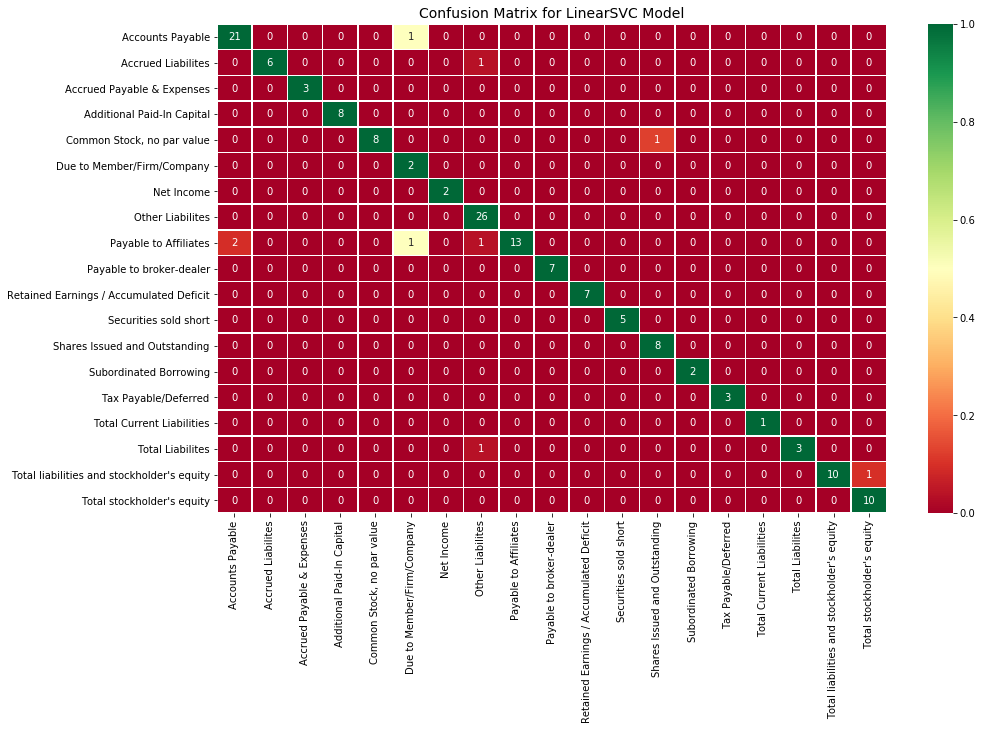

In [48]:
plt.figure(figsize=(15, 9))
plt.title('Confusion Matrix for LinearSVC Model (in-sample)', fontsize=14)
scaled_df = (cmat - cmat.min(axis=0)) / (cmat.max(axis=0) - cmat.min(axis=0))
sns.heatmap(scaled_df, annot=cmat, fmt="d", linewidths=.5, cmap="RdYlGn")
plt.show()

### Out-of-sample Label Predictions

In [ ]:
mdl1.predict(HashingVectorizer(n_features=500).fit_transform(["TOTAL LIABILITIES AND MEMBERS' EQUITY: "]))

## Consolidating Clusters to Structured Database
**Structured convergece for Unstructured data labels**

In [133]:
# journal of physics A, Journal Stat. Physics
def structured_data(unstructured_df:pd.DataFrame, cluster_df:pd.DataFrame, label_names:np.array) -> pd.DataFrame:
    """
    Constructs a structured dataset from an unstructured column set
    
    :param: unstructured_df (type pandas.DataFrame)
        unstuructured pandas dataframe with loose column construction 
    :param: cluster_df (type pandas.DataFrame)
        a pandas dataframe of clustered labels and corresponding line items
    :param: (type numpy array)
        all corresponding cluster labels cirresponding with 'cluster_df' parameter
        
    :return: (type pandas DataFrame)
    """
    
    structured_df = pd.DataFrame()
    
    # assume that the there exists columns 'CIK' and 'Year' for unstructured data
    structured_df = unstructured_df[['CIK', 'Year']]
    
    for label in label_names:
        data = cluster_df[cluster_df['Labels'] == label]['LineItems']     # filter by corresponding cluster
        
        # sum all columns, across row and map to structured dataframe
        structured_df[label] = unstructured_df[data.values].sum(axis=1)
        
    return structured_df

In [134]:
structured_data(assets, df, df['Labels'].unique())

,CIK,Year,3,2,4,6,11,14,10,0,9,13,7,5,1,12,8
0,1000147,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74600.0,0.0,0.0
1,1000147,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75800.0,0.0,0.0
2,1000147,2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76500.0,0.0,0.0
3,1000147,2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000147,2006,36301.0,0.0,332085.0,0.0,0.0,0.0,15788.0,0.0,2005.0,0.0,0.0,42132.0,253652.0,0.0,395.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,1000320,2009,0.0,0.0,0.0,0.0,13000.0,0.0,0.0,653311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,1000320,2010,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,88052.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,1000320,2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,1000320,2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
